In [1]:
%matplotlib inline
import os
import gzip
import pickle
import glob
import datetime
import warnings

from multiprocessing import Pool

import netCDF4
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl

warnings.simplefilter("ignore")

In [2]:
# From satellite comparison code.
SAT_OFF = {1998: 1.7,
 1999: 2.9,
 2001: 0,
 2002: -1.0,
 2003: -1.6,
 2004: 0,
 2005: -1.4,
 2006: 0,
 2009: 2.9,
 2010: 3.6,
 2011: 2.1,
 2012: 0.9,
 2013: 0.9,
 2014: 0.9,
 2015: 0,
 2016: 2.1}

In [14]:
def read_data(flist):
    rca = np.array([])
    rain = np.array([])
    dtime = np.array([], dtype=np.datetime64)
    for fd in flist:
        with netCDF4.Dataset(fd, 'r') as ncid:
            time = ncid['time'][:]
            rca_tmp = ncid['rca'][:]

            dtime_tmp = netCDF4.num2date(time, ncid['time'].units)
            rca = np.append(rca, rca_tmp)
            dtime = np.append(dtime, dtime_tmp)
            rain = np.append(rain, ncid["rain"][:])

    pos = np.argsort(dtime)
    dtime = dtime[pos]
    rca = rca[pos]
    rain = rain[pos]
    
    return dtime, rca, rain

In [4]:
def get_data(dtime, rca, rain, year=2016):
    rain[np.isnan(rain)] = 0
    rca_norain = rca.copy()
    rca_rain = rca.copy()
    rca_norain[rain > 1] = np.NaN
    rca_rain[rain <= 1] = np.NaN
    
    st = datetime.datetime(year, 10, 1)
    ed = datetime.datetime(year + 1, 6, 1)
    fpos = lambda x: (x > st) & (x < ed)

    pos = fpos(dtime)
    ul = np.percentile(rca[pos], 99.)
    ll = np.percentile(rca[pos], 1)
    x = dtime[pos]
    y0 = rca_norain[pos]
    y0[(y0 > ul) | (y0 < ll)] = np.NaN
    y1 = rca_rain[pos]
    y1[(y1 > ul) | (y1 < ll)] = np.NaN
    
    return x, y0, y1, st, ed

In [5]:
def get_data2(dtime, rca, year=2016):    
    rca_tot= rca.copy()
    
    st = datetime.datetime(year, 10, 1)
    ed = datetime.datetime(year + 1, 6, 1)
    fpos = lambda x: (x > st) & (x < ed)

    pos = fpos(dtime)
    x = dtime[pos]
    y0 = rca_tot[pos]
    
    return x, y0, st, ed

In [6]:
def get_limits(arr0, arr1=None):
    if arr1 is None:
        mi0 = np.nanmin(arr0)
        ma0 = np.nanmax(arr0)
        ll = 10 * np.floor(mi0 / 10)
        ul = 10 * np.ceil(ma0 / 10)
    else:
        mi0 = np.nanmin(arr0)
        ma0 = np.nanmax(arr0)
        mi1 = np.nanmin(arr1)
        ma1 = np.nanmax(arr1)
        minval = np.nanmin([mi0, mi1])
        maxval = np.nanmax([ma0, ma1])
        ll = 10 * np.floor(minval / 10)
        ul = 10 * np.ceil(maxval / 10)
    
    return ll, ul

In [24]:
# indir = "../saved_rca/netcdf/"
indir = "../saved_rca_rain/RCA_CPOL_2002-10-29T08:30:09_to_2003-07-14T02:00:09.nc"
flist = sorted(glob.glob(os.path.join(indir, "*.nc")))
dtime, rca, rain = read_data([indir])

In [25]:
dtime

array([datetime.datetime(2002, 10, 29, 8, 30, 9),
       datetime.datetime(2002, 10, 29, 8, 50, 9),
       datetime.datetime(2002, 10, 29, 9, 0, 9), ...,
       datetime.datetime(2003, 7, 14, 1, 40, 9),
       datetime.datetime(2003, 7, 14, 1, 50, 8),
       datetime.datetime(2003, 7, 14, 2, 0, 9)], dtype=object)

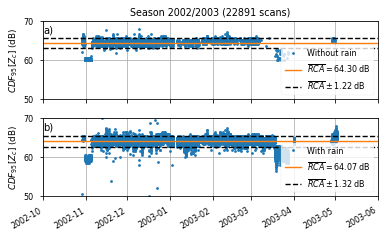

In [32]:
# def plot_data(dtime, rca, rain, year):
year = 2002
try:
    x, y0, y1, st, ed = get_data(dtime, rca, rain, year)
except IndexError:
    print("No data for given year.")    

if year == 2002:
    y0[y0 < 60] = np.NaN

y0mean = np.nanmean(y0)
y0std = np.nanstd(y0)
y1mean = np.nanmean(y1)
y1std = np.nanstd(y1)

ll, ul= get_limits(y0, y1)    

with pl.style.context("seaborn-paper"):
    fig, ax = pl.subplots(2, 1, sharex=True)
    ax = ax.flatten()

    ax[0].plot(x, y0, ".", label="Without rain")
    ax[0].plot([st, ed], [y0mean, y0mean], label="$\overline{RCA} = %0.2f$ dB" % (y0mean))
    ax[0].plot([st, ed], [y0mean + y0std, y0mean + y0std], "k--", label="$\overline{RCA} \pm %0.2f$ dB" % (y0std))
    ax[0].plot([st, ed], [y0mean - y0std, y0mean - y0std], "k--")
    ax[0].set_ylabel(r"$CDF_{95} \left[Z_c \right]$ (dB)")
    ax[0].set_title("Season {}/{} ({} scans)".format(year, year + 1, len(x)))

    ax[1].plot(x, y1, ".", label="With rain")
    ax[1].plot([st, ed], [y1mean, y1mean], label="$\overline{RCA} = %0.2f$ dB" % (y1mean))
    ax[1].plot([st, ed], [y1mean + y1std, y1mean + y1std], "k--", label="$\overline{RCA} \pm %0.2f$ dB" % (y1std))
    ax[1].plot([st, ed], [y1mean - y1std, y1mean - y1std], "k--")
    ax[1].set_ylabel(r"$CDF_{95} \left[Z_c \right]$ (dB)")
    
    ax[0].text(st, 69, "a)", va="top")
    ax[1].text(st, 69, "b)", va="top")

    for myax in ax:
        myax.set_xlim(st, ed)
        myax.set_ylim(50, 70)
        myax.legend(loc=4)
        myax.grid()

    fig.autofmt_xdate()
    
    width = 5.5
    height = width / 1.618
    fig.set_size_inches(width, height)
    fig.tight_layout()
#     pl.savefig("rca_rain.png", dpi=600)

In [8]:
def get_ref_mean(dataf):
    return dataf[dataf > dataf.quantile(0.25)].y0.mean()

In [9]:
def make_plot(year):
    try:
        x, y0, st, ed = get_data2(dtime, rca, year)
    except Exception:
        return None
    
    if np.nanmean(y0) > 100:
        y0 = y0 / 2 - 32.
        
    df = pd.DataFrame({"y0": y0}, index=x)
    df = df[(df < df.quantile(0.95)) & (df > df.quantile(0.05))]
    dfh = df.resample("1h").mean()
    dfd = df.resample("1d").mean()
    yhm = get_ref_mean(dfh)
    ydm = get_ref_mean(dfd)
    ll, ul = get_limits(dfh.y0.values)

    with pl.style.context("bmh"):
        fig, ax = pl.subplots(3, 1, sharex=True, figsize=(10, 8))
        ax = ax.flatten()

        ax[0].plot(dfh.index, dfh.y0, "+")
        ax[0].plot([st, ed], [yhm, yhm], "--", label="$\overline{RCA} = %0.2f$ dB" % (yhm))
        ax[0].set_ylabel("RCA (dB)")
        ax[0].set_title("Season {}/{} ({} scans)".format(year, year + 1, len(x)))

        ax[1].plot(dfd.index, dfd.y0, "+")
        ax[1].plot([st, ed], [ydm, ydm], "--", label="$\overline{RCA} = %0.2f$ dB" % (ydm))
        ax[1].set_ylabel("RCA (dB)")
        
        yyy = ydm - dfd.y0
        yyy = np.ma.masked_where(np.isnan(yyy), yyy)
        dy = np.gradient(yyy)
        dy[np.isnan(dy)] = 0
        dy[np.abs(dy) < 0.15] = 0
        yyy = np.cumsum(dy) + yyy[~np.isnan(yyy)][0]
        xoff = dfd.index
        offset = yyy + SAT_OFF[year]
        ax[2].plot(xoff, offset, "+")
        # ax[2].plot([st, ed], [ydm, ydm], "--", label="$\overline{RCA} = %0.2f$ dB" % (ydm))
        ax[2].set_ylabel("Offset (dB)")

        for cnt, myax in enumerate(ax):
            myax.set_xlim(st, ed)
            if cnt < 2:
                myax.set_ylim(ll, ul)
            else:
                myax.set_ylim(-10, 10)
            myax.legend(loc=4)
    #         myax.grid()

        fig.autofmt_xdate()
        fig.tight_layout()

        pl.show()
        
    return xoff, offset

In [19]:
# rslt = [make_plot(yr) for yr in range(1998, 2017) if yr not in [2000, 2007, 2008]]